# Question 3

## What are the factors affecting the prices ? ?

### Introduction





This notebook contains the analysis performed to solve our third question about the **What are the factors affecting the prices ?** in **Paris** in **June** 2022.
The data was collected from [**Inside Airbnb** website](http://insideairbnb.com/get-the-data/).
Check this section to get the [**listings**](http://data.insideairbnb.com/france/ile-de-france/paris/2022-06-06/data/listings.csv.gz) data, the [**calendar**](http://data.insideairbnb.com/france/ile-de-france/paris/2022-06-06/data/calendar.csv.gz) and also the [**reviews**](http://data.insideairbnb.com/france/ile-de-france/paris/2022-06-06/data/reviews.csv.gz) data provided in **Paris, Île-de-France, France** section.
This data will be used to answer the questions and complete this analysis about **Paris-Airbnb-data**.





In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from utils.preprocessing import preprocess, format_availability, format_prices
import re
from matplotlib.cbook import boxplot_stats
from collections import Counter

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import skew


In [2]:
# Reading the data files
listings = pd.read_csv('data/paris-airbnb/listings.csv')


In [3]:
# Preprocess the listings dataframes and remove raws with missing, price, neighbourhood, host_neighbourhood
# and host_location
listings = preprocess(listings,columns_of_interest=['neighbourhood','host_neighbourhood','price','host_location'])


In [4]:
# Format the prices and delete the "$" sign
data = format_prices(listings,columns=['price'])

# Outliers detection and removal

In [ ]:
listings['price'].plot(kind='box')
plt.savefig('blog/outliers.jpg',bbox_inches='tight')

In [ ]:
# Boxplot of price column

sns.boxplot(y='price',data=data)
plt.xticks(rotation=90)
plt.ylabel('Price ($)');
plt.savefig('blog/outliers_removed.jpg',bbox_inches='tight')


As we can see there are some points that are far from other points distribution, these are **outliers** and there are a lot of techniques to detect them.

This is a useful links about [outlier detection ](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba) [z-score and modified z-score](http://colingorrie.github.io/outlier-detection.html)




## IQR (Interquantile range)

In [ ]:
q1 = listings.price.quantile(0.25)
q3 = listings.price.quantile(0.75)
interquantile_range = q3-q1
data = listings[~((listings.price<(q1-1.5*interquantile_range)) | (listings.price>(q3+1.5*interquantile_range)))]

## Modified Z-score

In [ ]:

df_price = pd.DataFrame(listings.price)

mean = np.mean(df_price.price)
std = np.std(df_price.price)
df_price['Z-score'] = (df_price.price - mean) / std
median = np.median(df_price.price)
df_price['AD (Absolute Deviation)'] = abs(df_price.price - median)
mean_absolute_deviation = np.mean(df_price['AD (Absolute Deviation)'])
df_price['Modified Z-score'] = (0.6745*df_price['AD (Absolute Deviation)'])/ mean_absolute_deviation
df_outlier = df_price[df_price['Modified Z-score'] >= 3.5]

data = listings.drop(index = df_outlier.index)


# Correlation matrix

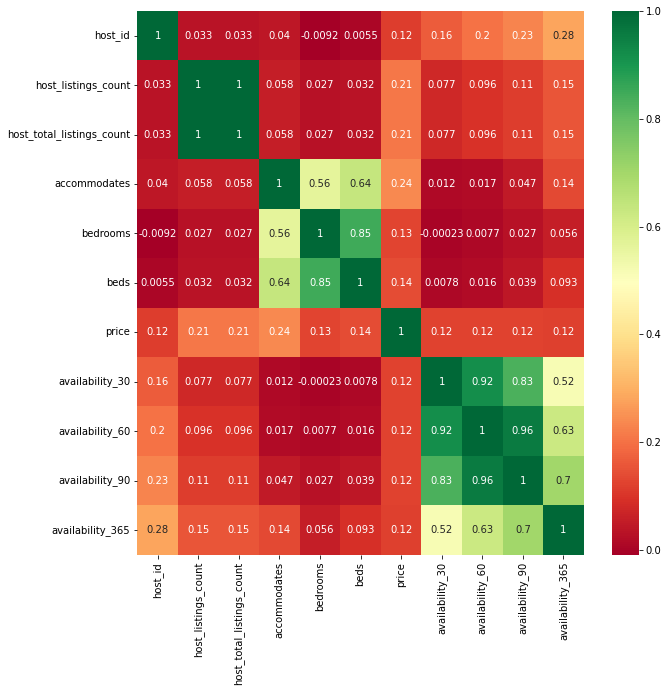

In [5]:
corr = data.corr()
highly_corr_features = corr.index[abs(corr["price"])>0.1]
plt.figure(figsize=(10,10))
map = sns.heatmap(data[highly_corr_features].corr(),annot=True,cmap="RdYlGn")


We can notice that the correlation of the variables improved after removing outliers using **IQR** technique and here is the scatter of **prices** vs **accommmodates** 

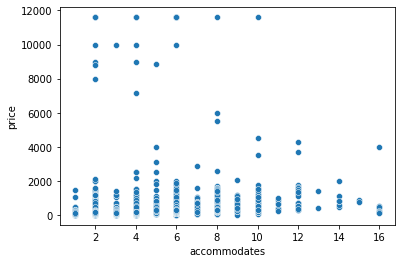

In [6]:
sns.scatterplot(data=data,x='accommodates',y='price');

# Numeric data 

## Dealing with missing values

In [7]:
numeric_data = data.select_dtypes(exclude='object')
numeric_data.head()

,listing_id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
6,26767859,20220606014139,7786899,3.0,3.0,48.902930,2.391530,2,1.0,1.0,...,4.00,4.00,5.00,4.00,4.00,3,1,2,0,0.03
11,595468760998844211,20220606014139,50502817,183.0,183.0,48.857019,2.220072,4,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,134,133,1,0,NaN
40,36504421,20220606014139,402191311,0.0,0.0,48.820420,2.246150,2,NaN,1.0,...,4.77,4.85,4.77,4.75,4.29,204,203,0,0,1.36
52,623628739025164042,20220606014139,374552379,0.0,0.0,48.809925,2.359981,2,NaN,1.0,...,5.00,4.00,5.00,4.00,5.00,72,72,0,0,1.00
125,47775531,20220606014139,434359594,0.0,0.0,48.834650,2.229750,2,NaN,1.0,...,4.83,4.83,4.72,4.78,4.22,14,14,0,0,1.47



First, we're going to discard the columns that are not useful in predicting the price of listings.



In [8]:
used_cols = ['host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365', 
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month']

In [9]:
numeric_data = numeric_data[used_cols]
numeric_data.describe()

,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,21059.000000,21059.000000,21059.000000,21059.000000,21059.000000,17486.000000,20932.000000,21059.000000,21059.000000,21059.000000,...,18246.000000,18240.000000,18243.000000,18241.000000,18240.000000,21059.000000,21059.000000,21059.000000,21059.00000,18428.000000
mean,12.337813,12.337813,48.863870,2.345123,3.192127,1.434919,1.820992,160.666176,93.042072,775.058027,...,4.619996,4.798709,4.812503,4.805818,4.619389,15.781519,14.995584,0.503300,0.01510,0.824136
std,47.259576,47.259576,0.018017,0.033349,1.672756,1.220908,1.675538,395.609884,167.255719,1026.161255,...,0.457546,0.356007,0.351375,0.303159,0.405712,40.090812,40.013201,2.577643,0.25592,1.193389
min,0.000000,0.000000,48.803770,2.218560,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.010000
25%,1.000000,1.000000,48.851160,2.325070,2.000000,1.000000,1.000000,70.000000,2.000000,90.000000,...,4.490000,4.750000,4.780000,4.750000,4.500000,1.000000,1.000000,0.000000,0.00000,0.130000
50%,1.000000,1.000000,48.865160,2.348390,2.000000,1.000000,1.000000,100.000000,4.000000,1125.000000,...,4.750000,4.910000,4.930000,4.900000,4.700000,1.000000,1.000000,0.000000,0.00000,0.400000
75%,2.000000,2.000000,48.877860,2.369300,4.000000,2.000000,2.000000,170.000000,90.000000,1125.000000,...,4.920000,5.000000,5.000000,5.000000,4.860000,3.000000,2.000000,0.000000,0.00000,1.010000
max,1246.000000,1246.000000,48.912910,2.486810,16.000000,50.000000,90.000000,11600.000000,9999.000000,99999.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,233.000000,233.000000,33.000000,8.00000,31.110000



We noticed that there's some missing values in certain columns, let's visualize that :


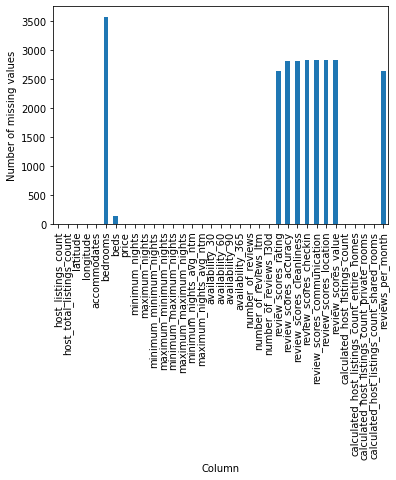

In [10]:

(numeric_data.isnull().sum()).plot(kind='bar') 
plt.savefig("blog/Missing_values_in_numeric_data.jpg",bbox_inches='tight')
plt.xlabel('Column')
plt.ylabel('Number of missing values')
plt.show()


Most of the missing values are within **bedrooms** and columns related to **reviews**. 
We can delete rows with missing bedrooms because imputing those values will never be logical for our model to learn. 
For the review scores, we can impute the missing values with the **mean** for all review columns and **median** for **beds** column.

In [11]:
numeric_data = numeric_data.dropna(axis=0,subset=['bedrooms'])

In [12]:
review_columns = ['review_scores_rating','review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','reviews_per_month']

In [13]:
# Use mean function to fill the reviews missing values 

fill_mean = lambda col: col.fillna(col.mean()) # Mean function

filled_reviews = numeric_data[review_columns].apply(fill_mean, axis=0) 

In [14]:
numeric_data['beds'] = numeric_data['beds'].fillna(numeric_data['beds'].median())

In [15]:
numeric_data = numeric_data.drop(columns=review_columns)

In [16]:
imputed_numeric = pd.concat([numeric_data,filled_reviews],axis=1).dropna()
imputed_numeric.head()

,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
6,3.0,3.0,48.902930,2.391530,2,1.0,1.0,18.0,2,1125,...,2,0,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,0.030000
11,183.0,183.0,48.857019,2.220072,4,2.0,1.0,267.0,3,365,...,1,0,4.643964,4.772591,4.633563,4.804474,4.818667,4.807261,4.634612,0.810362
161,183.0,183.0,48.887100,2.245870,4,1.0,1.0,79.0,30,365,...,1,0,4.643964,4.772591,4.633563,4.804474,4.818667,4.807261,4.634612,0.810362
250,0.0,0.0,48.850000,2.235290,2,1.0,1.0,192.0,90,1125,...,0,0,4.643964,4.772591,4.633563,4.804474,4.818667,4.807261,4.634612,0.810362
257,4.0,4.0,48.869360,2.225810,2,1.0,1.0,70.0,10,800,...,0,0,4.490000,4.810000,4.700000,4.700000,4.790000,4.770000,4.560000,0.700000


In [17]:
imputed_numeric.describe()

,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,...,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000,17486.000000
mean,12.230470,12.230470,48.863969,2.345425,3.396603,1.434919,1.944241,173.613176,85.799211,762.919650,...,0.591273,0.017900,4.643964,4.772591,4.633563,4.804474,4.818667,4.807261,4.634612,0.810362
std,49.202419,49.202419,0.018165,0.033323,1.741921,1.220908,1.796426,409.768709,166.345571,1106.614943,...,2.808580,0.280059,0.546721,0.323167,0.414950,0.324442,0.316777,0.274278,0.362298,1.104644
min,0.000000,0.000000,48.803770,2.218560,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,1.000000,1.000000,48.851130,2.325372,2.000000,1.000000,1.000000,75.000000,2.000000,80.000000,...,0.000000,0.000000,4.600000,4.740000,4.540000,4.800000,4.818667,4.780000,4.560000,0.160000
50%,1.000000,1.000000,48.865370,2.348520,3.000000,1.000000,2.000000,110.000000,4.000000,1125.000000,...,0.000000,0.000000,4.730000,4.830000,4.690000,4.880000,4.900000,4.860000,4.670000,0.520000
75%,2.000000,2.000000,48.878277,2.369747,4.000000,2.000000,2.000000,190.000000,30.000000,1125.000000,...,0.000000,0.000000,4.910000,4.970000,4.910000,5.000000,5.000000,5.000000,4.840000,0.880000
max,1246.000000,1246.000000,48.912910,2.486390,16.000000,50.000000,90.000000,11600.000000,9999.000000,99999.000000,...,33.000000,8.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,31.110000


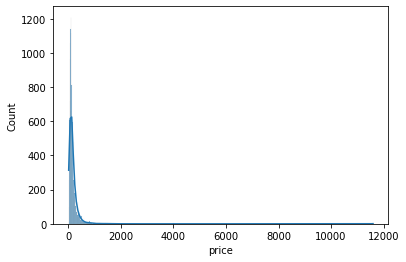

In [18]:
# Plot the Prices histogram
hist = sns.histplot(imputed_numeric['price'],kde=True);

fig = hist.get_figure()
fig.savefig('blog/Price_histogram.jpg')



Our **Price** column is right skewed, let's take a look at other columns.


In [19]:
#Top skewed columns
numeric_features = imputed_numeric.columns
skewed_features = imputed_numeric.apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
high_skew_df = pd.DataFrame(high_skew,columns=['skew'])
high_skew_df

,skew
minimum_maximum_nights,76.326056
maximum_nights,66.908403
maximum_nights_avg_ntm,60.555905
maximum_maximum_nights,49.949979
beds,26.881024
bedrooms,25.631300
price,21.429026
calculated_host_listings_count_shared_rooms,21.088486
number_of_reviews_ltm,14.614361
host_listings_count,14.468064



Then we can work on the most skewed columns to remove skewness and apply **log(x+1)** to transform their values.



In [20]:
new = imputed_numeric.copy()
#Transforming skewed columns
for feature in high_skew.index:
    new[feature] = np.log1p(new[feature])


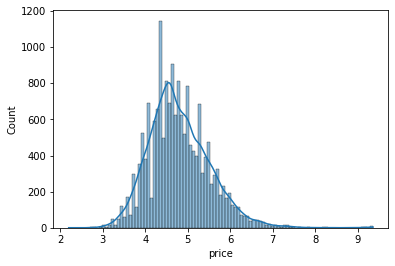

In [21]:
# Plot the Prices histogram after removing the skewness 

hist = sns.histplot(new['price'],kde=True);
fig = hist.get_figure()
fig.savefig('blog/Price_adjusted.jpg')


Our **price** feature does not perfectly the normal distribution but it's around the mean and less skewed.


# Categorical data

In [22]:
categorical_data = data.select_dtypes(include='object')
categorical_data.head()

,listing_url,last_scraped,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,host_location,...,property_type,room_type,bathrooms_text,amenities,available,date,first_review,last_review,license,instant_bookable
6,https://www.airbnb.com/rooms/26767859,2022-06-07,Private room in a beautiful duplex next to Paris,Private room in a nice duplex (with two rooms)...,10 minutes walk from the Parc de la Villette (...,https://a0.muscache.com/pictures/1de4e19a-a452...,https://www.airbnb.com/users/show/7786899,Nádia,2013-07-28,"Paris, Île-de-France, France",...,Private room in rental unit,Private room,1.5 shared baths,"[""Refrigerator"", ""Wifi"", ""Oven"", ""Host greets ...",t,2022-06-07,2019-09-28,2019-09-28,NaN,f
11,https://www.airbnb.com/rooms/595468760998844211,2022-06-06,★Duplex for 4p in St Cloud with a large terrace★,I will be delighted to welcome you to my charm...,ST CLOUD RACECOURSE <br />Situated on a platea...,https://a0.muscache.com/pictures/miso/Hosting-...,https://www.airbnb.com/users/show/50502817,Pierre De WeHost,2015-12-04,"Paris, Île-de-France, France",...,Entire rental unit,Entire home/apt,2 baths,"[""Refrigerator"", ""Wifi"", ""Oven"", ""Host greets ...",t,2022-06-06,NaN,NaN,NaN,t
40,https://www.airbnb.com/rooms/36504421,2022-06-06,GuestReady - Charming studio in Issy-les-Mouli...,"Located in a quiet residential area, this apar...","The parks are numerous in the city, conducive ...",https://a0.muscache.com/pictures/0af527b0-1226...,https://www.airbnb.com/users/show/402191311,GuestReady,2021-05-18,GB,...,Entire rental unit,Entire home/apt,1.5 baths,"[""Refrigerator"", ""Free residential garage on p...",t,2022-06-06,2019-07-16,2022-05-30,9204000014635,t
52,https://www.airbnb.com/rooms/623628739025164042,2022-06-06,Charming 2BR studio - Place d'Italie / Kremlin...,This charming renovated studio is located in t...,This studio is located in the 13th arrondissem...,https://a0.muscache.com/pictures/prohost-api/H...,https://www.airbnb.com/users/show/374552379,Joffrey,2020-11-05,"Paris, Île-de-France, France",...,Entire rental unit,Entire home/apt,1 bath,"[""Refrigerator"", ""Wifi"", ""Clothing storage"", ""...",t,2022-06-06,2022-05-15,2022-05-15,NaN,t
125,https://www.airbnb.com/rooms/47775531,2022-06-06,"Cozy studio with balcony, Boulogne-Billancourt",You will spend a pleasant stay in my 20sqm stu...,"The studio is located in Boulogne-Billancourt,...",https://a0.muscache.com/pictures/70f470b0-1ed2...,https://www.airbnb.com/users/show/434359594,Ghislaine,2021-12-02,"Boulogne-Billancourt, Île-de-France, France",...,Entire rental unit,Entire home/apt,1 bath,"[""Refrigerator"", ""Wifi"", ""Clothing storage"", ""...",t,2022-06-06,2021-06-04,2022-05-28,92012-000428-15,f


In [23]:
used_columns = ['last_scraped', 
       'host_since', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type',
       'bathrooms_text', 'amenities', 'available', 'date', 'first_review',
       'last_review', 'instant_bookable']



We are going to delete some columns related to listing description and also host unuseful information like **host_picture_url**. Then we'll plot the missing values to investigate.



In [24]:
categorical_data = categorical_data[used_columns]
categorical_data.head()

,last_scraped,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_verifications,host_has_profile_pic,...,neighbourhood_cleansed,property_type,room_type,bathrooms_text,amenities,available,date,first_review,last_review,instant_bookable
6,2022-06-07,2013-07-28,"Paris, Île-de-France, France",a few days or more,0%,0%,f,Châtelet - Les Halles - Beaubourg,"['email', 'phone']",t,...,Buttes-Chaumont,Private room in rental unit,Private room,1.5 shared baths,"[""Refrigerator"", ""Wifi"", ""Oven"", ""Host greets ...",t,2022-06-07,2019-09-28,2019-09-28,f
11,2022-06-06,2015-12-04,"Paris, Île-de-France, France",NaN,NaN,NaN,f,Nation,['phone'],t,...,Passy,Entire rental unit,Entire home/apt,2 baths,"[""Refrigerator"", ""Wifi"", ""Oven"", ""Host greets ...",t,2022-06-06,NaN,NaN,t
40,2022-06-06,2021-05-18,GB,NaN,NaN,NaN,f,Bastille,"['email', 'phone']",t,...,Passy,Entire rental unit,Entire home/apt,1.5 baths,"[""Refrigerator"", ""Free residential garage on p...",t,2022-06-06,2019-07-16,2022-05-30,t
52,2022-06-06,2020-11-05,"Paris, Île-de-France, France",NaN,NaN,NaN,f,Le Marais,[],t,...,Gobelins,Entire rental unit,Entire home/apt,1 bath,"[""Refrigerator"", ""Wifi"", ""Clothing storage"", ""...",t,2022-06-06,2022-05-15,2022-05-15,t
125,2022-06-06,2021-12-02,"Boulogne-Billancourt, Île-de-France, France",NaN,NaN,NaN,f,Porte de Versailles,"['email', 'phone']",t,...,Passy,Entire rental unit,Entire home/apt,1 bath,"[""Refrigerator"", ""Wifi"", ""Clothing storage"", ""...",t,2022-06-06,2021-06-04,2022-05-28,f


<Figure size 720x432 with 0 Axes>

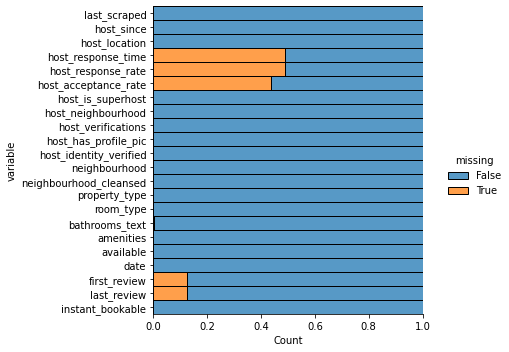

In [25]:
plt.figure(figsize=(10,6));
sns.displot(
    data=categorical_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
);
plt.savefig("blog/visualizing_missing_values_of_categorical_data_data.png", dpi=100);


In [26]:
categorical_data.isnull().sum().sort_values()

last_scraped                  0
date                          0
available                     0
amenities                     0
room_type                     0
property_type                 0
neighbourhood_cleansed        0
neighbourhood                 0
host_has_profile_pic          0
host_identity_verified        0
host_neighbourhood            0
host_is_superhost             0
host_location                 0
host_since                    0
host_verifications            0
instant_bookable              0
bathrooms_text               33
last_review                2631
first_review               2631
host_acceptance_rate       9196
host_response_rate        10289
host_response_time        10289
dtype: int64


We can see that most of the missing values correspond to **host-response_time**, **host_response_rate** and **host_acceptance_rate**, then comes a small portion about **15%** of **first_review** and **last_review** that can be dropped to avoid having some bias towards one of the dates.




In [27]:
# Let's drop the first and last review dates
categorical_data = categorical_data.dropna(subset=['first_review','last_review'],axis=0)


In [28]:
def create_new_features(data: pd.DataFrame) -> pd.DataFrame:
    """This utility function allows us to create some new features from our categorical columns.

    Arguments:
        data: The input dataframe.

    Returns:
        data: The output dataframe.

    """
    data["shared_bath"] = data["bathrooms_text"].str.findall(
        "shared", flags=re.IGNORECASE
    )
    data["private_bath"] = data["bathrooms_text"].str.findall(
        "private", flags=re.IGNORECASE
    )
    data.shared_bath = data.shared_bath.explode().fillna(-1)
    data.private_bath = data.private_bath.explode().fillna(-1)

    data.loc[data.shared_bath != -1, "shared_bath"] = 1
    data.loc[data.private_bath != -1, "private_bath"] = 1
    data[["shared_bath", "private_bath"]] = data[
        ["shared_bath", "private_bath"]
    ].astype(int)

    data["host_in_france"] = (
        data["host_location"].str.contains("france|fr", case=False).astype(int)
    )

    return data

In [29]:
def clean_bathrooms_data(
    data: pd.DataFrame, column: str = "bathrooms_text"
) -> pd.DataFrame:
    """This utility function allows us to clean the bathrooms_text column
    and generate ne features from it.

    Arguments:
        data: The input dataframe.
        column: The column of interest.

    Returns:
        data: The output dataframe preprocessed.
    """
    data = create_new_features(data)

    data["bathrooms_text"] = data.bathrooms_text.str.replace("bath|Bath", "")
    data["bathrooms_text"] = data.bathrooms_text.str.replace("shared|Shared", "")

    data["bathrooms_text"] = data.bathrooms_text.str.replace("s", "")

    data["bathrooms_text"] = data.bathrooms_text.str.replace("Private|private", "")
    data["bathrooms_text"] = data.bathrooms_text.str.replace("half|Half", "0.5")
    data["bathrooms_text"] = data.bathrooms_text.str.replace("-", "")
    # Convert bathrooms_text column type and fill missing values with the median
    
    data["bathrooms_text"] = data["bathrooms_text"].astype("float16")
    data["bathrooms_text"] = data["bathrooms_text"].fillna(data["bathrooms_text"].median())
    return data

In [30]:
categorical_data = clean_bathrooms_data(categorical_data)


/tmp/ipykernel_438264/616671510.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  data["bathrooms_text"] = data.bathrooms_text.str.replace("bath|Bath", "")
/tmp/ipykernel_438264/616671510.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  data["bathrooms_text"] = data.bathrooms_text.str.replace("shared|Shared", "")
/tmp/ipykernel_438264/616671510.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  data["bathrooms_text"] = data.bathrooms_text.str.replace("Private|private", "")
/tmp/ipykernel_438264/616671510.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  data["bathrooms_text"] = data.bathrooms_text.str.replace("half|Half", "0.5")


In [31]:
def format_categorical_columns(data: pd.DataFrame) -> pd.DataFrame:
    """This utility function allows us to format some categorical columns for data cleaning.

    Arguments:
        data: The input dataframe.

    Returns:
        data: The output dataframe with formatted columns.
    """
    # Convert host_response_rate, host_acceptance_rate types and fill NaN values with the mean

    data["host_response_rate"] = (
        data["host_response_rate"].astype("str").str.rstrip("%").astype(float)
    )
    data['host_response_rate'] = data['host_response_rate'].fillna(data['host_response_rate'].mean())
    data["host_acceptance_rate"] = (
        data["host_acceptance_rate"].astype("str").str.rstrip("%").astype(float)
    )
    data['host_acceptance_rate'] = data['host_acceptance_rate'].fillna(data['host_acceptance_rate'].mean())
    
    # Convert columns values types 

    data["available"] = (
        data.available.str.replace("t", "1").replace("f", "0").astype(int)
    )
    data["host_is_superhost"] = (
        data.host_is_superhost.str.replace("t", "1").replace("f", "0").astype(int)
    )
    data["host_has_profile_pic"] = (
        data.host_has_profile_pic.str.replace("t", "1").replace("f", "0").astype(int)
    )
    data["host_identity_verified"] = (
        data.host_identity_verified.str.replace("t", "1").replace("f", "0").astype(int)
    )
    data["instant_bookable"] = (
        data.instant_bookable.str.replace("t", "1").replace("f", "0").astype(int)
    )
    
    # Create another feature to track the similarity between airbnb neighbourhood and host_neighbourhood

    data.loc[
        data["host_neighbourhood"] == data["neighbourhood"], "host_neighbourhood"
    ] = 1
    data.loc[data["host_neighbourhood"] != 1, "host_neighbourhood"] = 0
    data.rename(
        columns={"host_neighbourhood": "airbnb_in_host_neighbourhood"}, inplace=True
    )

    data["airbnb_in_host_neighbourhood"] = data["airbnb_in_host_neighbourhood"].astype(
        int
    )
    
    """ # Filling missing dates with bfill()
    data["last_review"] = data['last_review'].bfill()
    data["first_review"] = data['last_review'].bfill()
    """
    # Convert columns containing dates to datetime
    
    data["host_since"] = pd.to_datetime(data["host_since"]).astype(int) 
    data["first_review"] = pd.to_datetime(data["first_review"]).astype(int)
    data["last_review"] = pd.to_datetime(data["last_review"]).astype(int)
    data["first_review"] = pd.to_datetime(data["first_review"]).astype(int)
    data["last_scraped"] = pd.to_datetime(data["last_scraped"]).astype(int)
    data["date"] = pd.to_datetime(data["date"]).astype(int)
    
    # Drop unnecessary columns
    data.drop(
        columns=[
            "neighbourhood",
            "host_location",
            "neighbourhood_cleansed",
            "property_type",
        ],
        inplace=True,
    )

    return data


In [32]:
categorical_data = format_categorical_columns(categorical_data)

/tmp/ipykernel_438264/3801043139.py:59: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data["host_since"] = pd.to_datetime(data["host_since"]).astype(int)
/tmp/ipykernel_438264/3801043139.py:60: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data["first_review"] = pd.to_datetime(data["first_review"]).astype(int)
/tmp/ipykernel_438264/3801043139.py:61: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data["last_review"] = pd.to_datetime(data["last_review"]).astype(int)
/tmp/ipykernel_438264/3801043139.py:62: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data["first_review"] = pd.to_datetime(

In [33]:

def format_amenities(data: pd.DataFrame) -> pd.DataFrame:
    """This utility function is used to format amenities column.

    Arguments:
        data: The input dataframe.

    Returns:
        data: The output dataframe with formatted amenities."""
    # make a dictionary from the amenities
    amenities_counter = Counter()
    data["amenities"].astype("str").str.strip("[]").str.replace('"', "").str.split(
        ","
    ).apply(amenities_counter.update)

    # for the purpose of the project I'll take only the most 30 common amenities
    for item, _ in amenities_counter.most_common(30):
        col_name = "amenity_" + item.replace(" ", "_")
        data[col_name] = data["amenities"].astype("str").apply(lambda x: int(item in x))
    data.drop(columns=["amenities"], axis=1, inplace=True)

    return data

In [34]:
categorical_data = format_amenities(categorical_data)
categorical_data.head()

,last_scraped,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,airbnb_in_host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,...,amenity_Refrigerator,amenity__Dishwasher,amenity__Carbon_monoxide_alarm,amenity__Refrigerator,amenity__Dryer,amenity__Cable_TV,amenity__Paid_parking_off_premises,amenity__Extra_pillows_and_blankets,amenity__Host_greets_you,amenity__TV_with_standard_cable
6,1654560000000000000,1374969600000000000,a few days or more,0.000000,0.000000,0,0,"['email', 'phone']",1,1,...,1,0,0,0,0,0,0,0,0,0
40,1654473600000000000,1621296000000000000,NaN,93.140518,81.004353,0,0,"['email', 'phone']",1,0,...,1,0,0,0,0,0,0,0,0,0
52,1654473600000000000,1604534400000000000,NaN,93.140518,81.004353,0,0,[],1,0,...,1,0,0,0,0,0,0,0,0,0
125,1654473600000000000,1638403200000000000,NaN,93.140518,81.004353,0,0,"['email', 'phone']",1,1,...,1,0,0,0,0,0,0,0,0,0
257,1654473600000000000,1346630400000000000,within a day,71.000000,63.000000,0,0,"['email', 'phone']",1,1,...,1,0,0,0,0,0,0,0,0,0


In [35]:
def format_host_verifications(data: pd.DataFrame) -> pd.DataFrame:
    """This utility function is used to format host_verifications column.

    Arguments:
        data: The input dataframe.

    Returns:
        data: The output dataframe with formatted host_verifications.
    """
    # make a dictionary from the 'Host Verifications'
    verifications_counter = Counter()
    data["host_verifications"].astype("str").str.strip("[" "]").str.replace(
        "'", ""
    ).str.split(",").apply(verifications_counter.update)
    for item, _ in verifications_counter.most_common(10):
        col_name = "host_verifications" + item.replace(" ", "_")
        data[col_name] = (
            data["host_verifications"].astype("str").apply(lambda x: int(item in x))
        )
    data.drop(columns=["host_verifications"], axis=1, inplace=True)

    return data

In [36]:
categorical_data = format_host_verifications(categorical_data)
categorical_data.head()

,last_scraped,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,airbnb_in_host_neighbourhood,host_has_profile_pic,host_identity_verified,room_type,...,amenity__Dryer,amenity__Cable_TV,amenity__Paid_parking_off_premises,amenity__Extra_pillows_and_blankets,amenity__Host_greets_you,amenity__TV_with_standard_cable,host_verificationsemail,host_verifications_phone,host_verifications_work_email,host_verificationsphone
6,1654560000000000000,1374969600000000000,a few days or more,0.000000,0.000000,0,0,1,1,Private room,...,0,0,0,0,0,0,1,0,0,1
40,1654473600000000000,1621296000000000000,NaN,93.140518,81.004353,0,0,1,0,Entire home/apt,...,0,0,0,0,0,0,1,0,0,1
52,1654473600000000000,1604534400000000000,NaN,93.140518,81.004353,0,0,1,0,Entire home/apt,...,0,0,0,0,0,0,0,0,0,0
125,1654473600000000000,1638403200000000000,NaN,93.140518,81.004353,0,0,1,1,Entire home/apt,...,0,0,0,0,0,0,1,0,0,1
257,1654473600000000000,1346630400000000000,within a day,71.000000,63.000000,0,0,1,1,Entire home/apt,...,0,0,0,0,0,0,1,0,0,1



Now that we formatted **host_verifications**, we need to create dummy dataframe columns for categorical data.



In [37]:
categorical_data.head()

,last_scraped,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,airbnb_in_host_neighbourhood,host_has_profile_pic,host_identity_verified,room_type,...,amenity__Dryer,amenity__Cable_TV,amenity__Paid_parking_off_premises,amenity__Extra_pillows_and_blankets,amenity__Host_greets_you,amenity__TV_with_standard_cable,host_verificationsemail,host_verifications_phone,host_verifications_work_email,host_verificationsphone
6,1654560000000000000,1374969600000000000,a few days or more,0.000000,0.000000,0,0,1,1,Private room,...,0,0,0,0,0,0,1,0,0,1
40,1654473600000000000,1621296000000000000,NaN,93.140518,81.004353,0,0,1,0,Entire home/apt,...,0,0,0,0,0,0,1,0,0,1
52,1654473600000000000,1604534400000000000,NaN,93.140518,81.004353,0,0,1,0,Entire home/apt,...,0,0,0,0,0,0,0,0,0,0
125,1654473600000000000,1638403200000000000,NaN,93.140518,81.004353,0,0,1,1,Entire home/apt,...,0,0,0,0,0,0,1,0,0,1
257,1654473600000000000,1346630400000000000,within a day,71.000000,63.000000,0,0,1,1,Entire home/apt,...,0,0,0,0,0,0,1,0,0,1


In [38]:
categorical_cols = categorical_data.select_dtypes(include='object').columns

In [39]:
def create_dummy_df(data, categorical_cols, dummy_na=True):
    """
    This function is used to create a dummy dataframe from categorical columns
    having the following characteristics:
    
    1. contains all columns that were not specified as categorical
    2. dummy columns for each of the categorical columns in categorical_cols
    3. if dummy_na is True - it also contains dummy columns for the NaN values
    4. Use a prefix of the column name with an underscore (_) for separating 
    
    Arguments:
        data: The input dataframe.
        categorical_cols: A list with the categorical columns.
        dummy_na: A boolean specifying whether we add dummy columns for NaNs.
        
    Returns:
        data: The output dataframe having the mentioned characteristics.
        
    """
    
    
    data = data.dropna(how='all', axis=1)

    for col in  categorical_cols:
        try:
            # for each cat add dummy var, drop original column
            data = pd.concat([data.drop(col, axis=1), pd.get_dummies(data[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return data

In [40]:
categorical_data = create_dummy_df(categorical_data, categorical_cols, dummy_na=True)

In [41]:
final_data = pd.concat([new,categorical_data],axis=1)

In [42]:
final_data = final_data.drop_duplicates()

In [43]:
final = final_data.dropna()

In [44]:
final

,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,...,host_verifications_work_email,host_verificationsphone,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,room_type_Hotel room,room_type_Private room,room_type_Shared room,room_type_nan
6,1.386294,1.386294,48.902930,2.391530,1.098612,0.693147,0.693147,2.944439,1.098612,7.026427,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
257,1.609438,1.609438,48.869360,2.225810,1.098612,0.693147,0.693147,4.262680,2.397895,6.685861,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
311,1.098612,1.098612,48.876640,2.221240,1.098612,0.693147,0.693147,4.110874,1.098612,7.026427,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
400,0.693147,0.693147,48.896698,2.399389,1.609438,1.098612,1.386294,4.394449,1.791759,7.026427,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
421,4.488636,4.488636,48.886410,2.235370,1.945910,1.098612,1.791759,5.198497,2.079442,4.795791,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55776,5.214936,5.214936,48.890187,2.382253,1.098612,0.693147,0.693147,4.543295,1.386294,5.902633,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55923,4.110874,4.110874,48.864944,2.345212,1.609438,0.693147,1.098612,6.059123,1.386294,5.902633,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55946,2.995732,2.995732,48.855372,2.358522,1.098612,0.693147,0.693147,5.017280,1.386294,2.772589,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
56113,5.214936,5.214936,48.865996,2.332776,1.609438,0.693147,1.098612,5.257495,1.386294,5.902633,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


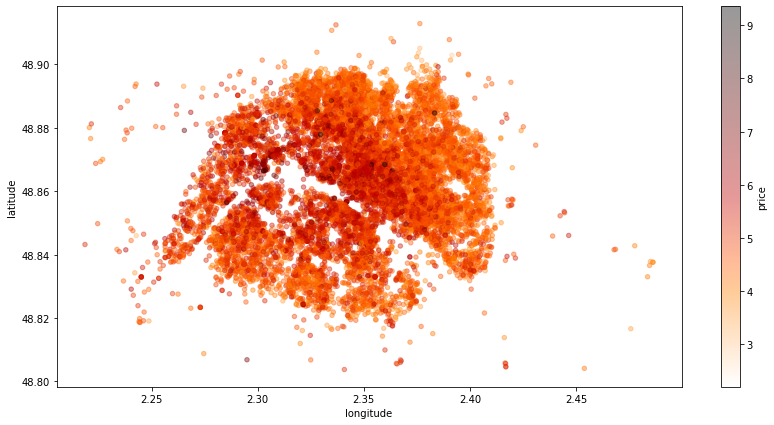

In [45]:
# Scatter the price with longitude and latitude 

final.plot(kind="scatter", 
                  x="longitude", y="latitude", 
                  alpha=0.4, figsize=(14,7), 
                  c="price", cmap="gist_heat_r", 
                  colorbar=True, sharex=False);


As we can see, **closer** we are to the city center **higher** the **price**.


## Train test split

In [46]:
# data preprocessing
import pandas as pd 
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model
import xgboost as xgb

In [47]:
y = final.loc[:,'price']
X = final.drop(columns=['price'], axis=1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=0.2, 
                                                                    random_state=42)

In [48]:
def find_best_params(X_train,y_train):
    """This function allows us to find the best parameters for XGB model 
        using the Grid Search algorithm.
    
    Arguments:
        X_train: The training features.
        y_train: The training label.
        
    Returns:
        best_params: A dictionary with the best parameters for XGB."""
    # -- Grid search -- 
    xgb_model = xgb.XGBRegressor()

    grid_param = {'n_estimators': [50, 100, 200],
                  'learning_rate': [1e-01, 5e-02, 1e-03], 
                  'max_depth': [3, 5, 7],
                  'colsample_bytree': [0.5, 0.7, 1],
                  'gamma': [0.0, 0.2, 1, 10]}   # how much conservative the algoritem will be 

    xgb_grid_search = model_selection.GridSearchCV(xgb_model, 
                                                   grid_param, 
                                                   cv=2,   # k-fold parameter for cross-validation 
                                                   n_jobs=2 # number of jobs in parallel, -1 means using all processors
                                                   )

    xgb_grid_search.fit(X_train, y_train,verbose=True)

    # -- Print the best parameters that found -- 
    best_params = xgb_grid_search.best_params_
    
    return best_params


In [49]:
def fit_data(X_train,y_train):
    """This function launches the training pipeline and fits the training features to labels.
    
    Arguments:
        X_train: The training features.
        y_train: The training label.
        
    Returns:
        booster: The trained model.
        results: The evaluation results.
    """
    best_params = find_best_params(X_train=X_train, y_train=y_train)
    # -- instantiate xgboost with best parameters --
    booster = xgb.XGBRegressor(colsample_bytree=best_params['colsample_bytree'], 
                               gamma=best_params['gamma'],
                               learning_rate=best_params['learning_rate'],
                               max_depth=best_params['max_depth'],
                               n_estimators=best_params['n_estimators'],
                               random_state=42, 
                               alpha=10)
    # -- Train --
    evalset = [(X_train, y_train), (X_test,y_test)]
    result = booster.fit(X_train, y_train,eval_metric=['rmse'] ,eval_set=evalset, verbose=1)

    results = booster.evals_result()
    
    return booster, results

In [50]:
%%time

model, results = fit_data(X_train,y_train)

[0]	validation_0-rmse:3.92424	validation_1-rmse:3.94022
[1]	validation_0-rmse:3.53981	validation_1-rmse:3.55498
[2]	validation_0-rmse:3.19409	validation_1-rmse:3.20901
[3]	validation_0-rmse:2.88381	validation_1-rmse:2.89840
[4]	validation_0-rmse:2.60535	validation_1-rmse:2.61982
[5]	validation_0-rmse:2.35525	validation_1-rmse:2.36947
[6]	validation_0-rmse:2.13094	validation_1-rmse:2.14561
[7]	validation_0-rmse:1.92983	validation_1-rmse:1.94401
[8]	validation_0-rmse:1.74962	validation_1-rmse:1.76354
[9]	validation_0-rmse:1.58824	validation_1-rmse:1.60230
[10]	validation_0-rmse:1.44401	validation_1-rmse:1.45739
[11]	validation_0-rmse:1.31509	validation_1-rmse:1.32807
[12]	validation_0-rmse:1.20025	validation_1-rmse:1.21308
[13]	validation_0-rmse:1.09744	validation_1-rmse:1.11029
[14]	validation_0-rmse:1.00651	validation_1-rmse:1.01910
[15]	validation_0-rmse:0.92602	validation_1-rmse:0.93867
[16]	validation_0-rmse:0.85509	validation_1-rmse:0.86806
[17]	validation_0-rmse:0.79189	validation

/home/medamine/anaconda3/envs/locust/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-rmse:0.45454	validation_1-rmse:0.47055
[29]	validation_0-rmse:0.44300	validation_1-rmse:0.45897
[30]	validation_0-rmse:0.43321	validation_1-rmse:0.44940
[31]	validation_0-rmse:0.42456	validation_1-rmse:0.44079
[32]	validation_0-rmse:0.41749	validation_1-rmse:0.43356
[33]	validation_0-rmse:0.41095	validation_1-rmse:0.42716
[34]	validation_0-rmse:0.40520	validation_1-rmse:0.42182
[35]	validation_0-rmse:0.40072	validation_1-rmse:0.41745
[36]	validation_0-rmse:0.39610	validation_1-rmse:0.41302
[37]	validation_0-rmse:0.39236	validation_1-rmse:0.40949
[38]	validation_0-rmse:0.38934	validation_1-rmse:0.40651
[39]	validation_0-rmse:0.38620	validation_1-rmse:0.40358
[40]	validation_0-rmse:0.38370	validation_1-rmse:0.40102
[41]	validation_0-rmse:0.38083	validation_1-rmse:0.39842
[42]	validation_0-rmse:0.37894	validation_1-rmse:0.39651
[43]	validation_0-rmse:0.37622	validation_1-rmse:0.39401
[44]	validation_0-rmse:0.37436	validation_1-rmse:0.39257
[45]	validation_0-rmse:0.37275	

[171]	validation_0-rmse:0.31500	validation_1-rmse:0.35657
[172]	validation_0-rmse:0.31478	validation_1-rmse:0.35655
[173]	validation_0-rmse:0.31463	validation_1-rmse:0.35648
[174]	validation_0-rmse:0.31442	validation_1-rmse:0.35643
[175]	validation_0-rmse:0.31412	validation_1-rmse:0.35625
[176]	validation_0-rmse:0.31388	validation_1-rmse:0.35617
[177]	validation_0-rmse:0.31372	validation_1-rmse:0.35614
[178]	validation_0-rmse:0.31351	validation_1-rmse:0.35613
[179]	validation_0-rmse:0.31338	validation_1-rmse:0.35605
[180]	validation_0-rmse:0.31316	validation_1-rmse:0.35594
[181]	validation_0-rmse:0.31294	validation_1-rmse:0.35575
[182]	validation_0-rmse:0.31273	validation_1-rmse:0.35553
[183]	validation_0-rmse:0.31256	validation_1-rmse:0.35553
[184]	validation_0-rmse:0.31241	validation_1-rmse:0.35546
[185]	validation_0-rmse:0.31230	validation_1-rmse:0.35545
[186]	validation_0-rmse:0.31213	validation_1-rmse:0.35544
[187]	validation_0-rmse:0.31197	validation_1-rmse:0.35543
[188]	validati

### Plot the most important features

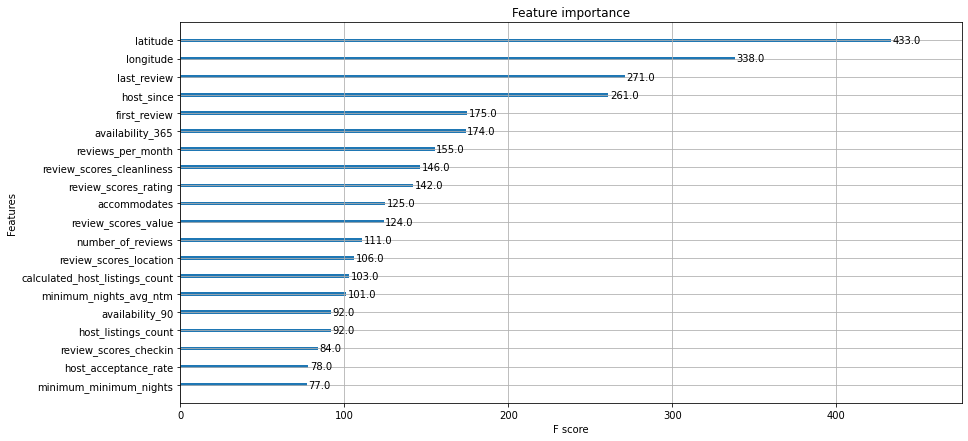

In [51]:
_, ax = plt.subplots(1,1,figsize=(14, 7))
xgb.plot_importance(booster=model, ax=ax, max_num_features=20)

plt.savefig('blog/feature-importance.jpg',bbox_inches='tight')
plt.show()

In [52]:
# -- cross validation -- 
best_params = {'objective': 'reg:squarederror',  #regression with squared loss
              'colsample_bytree': 0.7,
              'learning_rate': 0.1,
              'max_depth': 5, 
              'gamma':0.0}

In [53]:
xg_train = xgb.DMatrix(data=X_train, label=y_train) # help to speed up the procces and to save memory space

In [54]:
cv_results = xgb.cv(dtrain=xg_train, 
                    params=best_params, 
                    nfold=2,
                    num_boost_round=200, 
                    early_stopping_rounds=10, 
                    metrics="rmse",  # root mean square error (for regression)
                    as_pandas=True) 

In [55]:
predictions = model.predict(X_test)
model.score(X_test,y_test)

0.7560584065020556

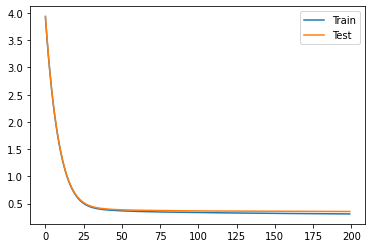

In [56]:
# -- plot learning curves --
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
plt.legend()
plt.savefig('blog/learning_curve.jpg')
plt.show()

In [58]:
np.sqrt(mean_squared_error(y_pred=predictions,y_true=y_test.values))

0.3546494400180462

# Random Forest

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),  
'min_samples_split': [2, 10, 9], 
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
'bootstrap': [True, False], 
'random_state': [1, 2, 30, 42]
}
model = RandomForestRegressor()
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(X_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

In [60]:
model_2 = RandomForestRegressor(n_estimators=500,random_state=30,min_samples_split=2,min_samples_leaf=3,max_depth=14,bootstrap=True)


In [61]:
model_2.fit(X_train,y_train)

RandomForestRegressor(max_depth=14, min_samples_leaf=3, n_estimators=500,
                      random_state=30)

In [62]:
pred = model_2.predict(X_test)

In [63]:
model_2.score(X_test,y_test)

0.7315765724028662

In [64]:
rms = mean_squared_error(y_test, pred, squared=False)
rms

0.37202023186211247

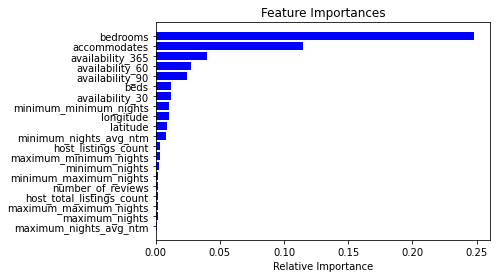

In [65]:
# Plot the feature importance for Random forest 

features=X_train.columns
importances = model.feature_importances_[:20]
indices = np.argsort(importances)[:20]

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

plt.savefig('blog/feature-importance_random_forest.jpg',bbox_inches='tight')
plt.show()